라이브러리

In [14]:
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230715_tank1_nonlinear_10min_all'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

#시계열 10분 단위로 변경
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.resample('10T', on='mea_dt').mean()
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.resample('10T', on='mea_dt').mean()

#null 삭제
japonica_training_sensor_val_tb.dropna(inplace=True)
japonica_validation_sensor_val_tb.dropna(inplace=True)

#인덱스 복구
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.reset_index()
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.reset_index()

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 144이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 144].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 144].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

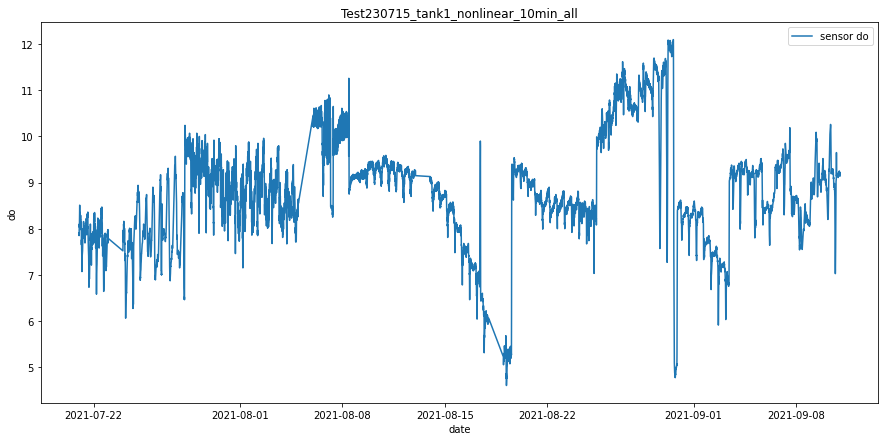

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(japonica_training_data.index, japonica_training_data["do_mg"], label='sensor do')  # x축에 년월일, y축에 값
plt.xlabel('date')
plt.ylabel('do')
plt.title(model_name)
plt.legend(['sensor do','prediction do','feed_quantity'])
plt.show()

In [8]:
japonica_training_features_X = japonica_training_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [9]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)

In [10]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6912 nVar: 9
nCar: 6912 nVar: 1
nCar: 6912 nVar: 9
nCar: 6912 nVar: 1


In [11]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-18]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[18:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-18]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[18:]

In [12]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6894 nVar: 9
nCar: 6894 nVar: 1
nCar: 6894 nVar: 9
nCar: 6894 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [15]:
# Create model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=9))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])
model.save(model_name+'.h5')

/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2023-07-15 03:44:55.689252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10000000


2023-07-15 03:44:57.201078: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


69/69 - 2s - loss: 6.2291 - val_loss: 1.6172
Epoch 2/10000000
69/69 - 1s - loss: 1.5791 - val_loss: 1.5111
Epoch 3/10000000
69/69 - 0s - loss: 1.5021 - val_loss: 1.4112
Epoch 4/10000000
69/69 - 1s - loss: 1.3825 - val_loss: 1.3744
Epoch 5/10000000
69/69 - 0s - loss: 1.3020 - val_loss: 1.2383
Epoch 6/10000000
69/69 - 1s - loss: 1.2123 - val_loss: 1.1579
Epoch 7/10000000
69/69 - 0s - loss: 1.1489 - val_loss: 1.0765
Epoch 8/10000000
69/69 - 1s - loss: 1.0524 - val_loss: 1.1650
Epoch 9/10000000
69/69 - 1s - loss: 0.9699 - val_loss: 0.8847
Epoch 10/10000000
69/69 - 1s - loss: 0.8735 - val_loss: 0.8059
Epoch 11/10000000
69/69 - 0s - loss: 0.8149 - val_loss: 0.7738
Epoch 12/10000000
69/69 - 1s - loss: 0.7514 - val_loss: 0.6807
Epoch 13/10000000
69/69 - 1s - loss: 0.6956 - val_loss: 0.6353
Epoch 14/10000000
69/69 - 1s - loss: 0.6475 - val_loss: 0.6404
Epoch 15/10000000
69/69 - 1s - loss: 0.6239 - val_loss: 0.6209
Epoch 16/10000000
69/69 - 1s - loss: 0.5877 - val_loss: 0.5553
Epoch 17/10000000


Epoch 131/10000000
69/69 - 1s - loss: 0.5204 - val_loss: 0.4978
Epoch 132/10000000
69/69 - 1s - loss: 0.5220 - val_loss: 0.5105
Epoch 133/10000000
69/69 - 1s - loss: 0.5602 - val_loss: 0.5549
Epoch 134/10000000
69/69 - 1s - loss: 0.5309 - val_loss: 0.5244
Epoch 135/10000000
69/69 - 1s - loss: 0.5202 - val_loss: 0.5733
Epoch 136/10000000
69/69 - 1s - loss: 0.5403 - val_loss: 0.5926
Epoch 137/10000000
69/69 - 1s - loss: 0.5307 - val_loss: 0.4981
Epoch 138/10000000
69/69 - 1s - loss: 0.5260 - val_loss: 0.5374
Epoch 139/10000000
69/69 - 0s - loss: 0.5094 - val_loss: 0.5022
Epoch 140/10000000
69/69 - 1s - loss: 0.5177 - val_loss: 0.5271
Epoch 141/10000000
69/69 - 1s - loss: 0.5141 - val_loss: 0.4990
Epoch 142/10000000
69/69 - 0s - loss: 0.5285 - val_loss: 0.4966
Epoch 143/10000000
69/69 - 1s - loss: 0.5404 - val_loss: 0.6050
Epoch 144/10000000
69/69 - 1s - loss: 0.5115 - val_loss: 0.5715
Epoch 145/10000000
69/69 - 0s - loss: 0.5682 - val_loss: 0.4938
Epoch 146/10000000
69/69 - 1s - loss: 0.

69/69 - 1s - loss: 0.4942 - val_loss: 0.5207
Epoch 260/10000000
69/69 - 1s - loss: 0.4963 - val_loss: 0.5017
Epoch 261/10000000
69/69 - 1s - loss: 0.5130 - val_loss: 0.5554
Epoch 262/10000000
69/69 - 1s - loss: 0.5135 - val_loss: 0.5061
Epoch 263/10000000
69/69 - 1s - loss: 0.4953 - val_loss: 0.4841
Epoch 264/10000000
69/69 - 1s - loss: 0.5051 - val_loss: 0.4875
Epoch 265/10000000
69/69 - 1s - loss: 0.5252 - val_loss: 0.4940
Epoch 266/10000000
69/69 - 1s - loss: 0.4930 - val_loss: 0.5075
Epoch 267/10000000
69/69 - 1s - loss: 0.4893 - val_loss: 0.4823
Epoch 268/10000000
69/69 - 1s - loss: 0.5036 - val_loss: 0.4886
Epoch 269/10000000
69/69 - 1s - loss: 0.4998 - val_loss: 0.4944
Epoch 270/10000000
69/69 - 1s - loss: 0.4959 - val_loss: 0.4767
Epoch 271/10000000
69/69 - 1s - loss: 0.4906 - val_loss: 0.4902
Epoch 272/10000000
69/69 - 1s - loss: 0.4880 - val_loss: 0.4819
Epoch 273/10000000
69/69 - 1s - loss: 0.5064 - val_loss: 0.5055
Epoch 274/10000000
69/69 - 1s - loss: 0.5094 - val_loss: 0.

Epoch 388/10000000
69/69 - 1s - loss: 0.4479 - val_loss: 0.4639
Epoch 389/10000000
69/69 - 1s - loss: 0.4581 - val_loss: 0.4610
Epoch 390/10000000
69/69 - 1s - loss: 0.4587 - val_loss: 0.4829
Epoch 391/10000000
69/69 - 1s - loss: 0.4594 - val_loss: 0.4567
Epoch 392/10000000
69/69 - 1s - loss: 0.4778 - val_loss: 0.4623
Epoch 393/10000000
69/69 - 1s - loss: 0.4451 - val_loss: 0.4342
Epoch 394/10000000
69/69 - 1s - loss: 0.4512 - val_loss: 0.4530
Epoch 395/10000000
69/69 - 1s - loss: 0.4443 - val_loss: 0.4470
Epoch 396/10000000
69/69 - 1s - loss: 0.4489 - val_loss: 0.4293
Epoch 397/10000000
69/69 - 1s - loss: 0.4460 - val_loss: 0.4300
Epoch 398/10000000
69/69 - 1s - loss: 0.4456 - val_loss: 0.4320
Epoch 399/10000000
69/69 - 1s - loss: 0.4417 - val_loss: 0.4650
Epoch 400/10000000
69/69 - 1s - loss: 0.4498 - val_loss: 0.4362
Epoch 401/10000000
69/69 - 1s - loss: 0.4471 - val_loss: 0.4448
Epoch 402/10000000
69/69 - 1s - loss: 0.4397 - val_loss: 0.4280
Epoch 403/10000000
69/69 - 1s - loss: 0.

69/69 - 1s - loss: 0.4283 - val_loss: 0.4048
Epoch 517/10000000
69/69 - 1s - loss: 0.4252 - val_loss: 0.4175
Epoch 518/10000000
69/69 - 1s - loss: 0.4360 - val_loss: 0.4052
Epoch 519/10000000
69/69 - 1s - loss: 0.4153 - val_loss: 0.4108
Epoch 520/10000000
69/69 - 1s - loss: 0.4259 - val_loss: 0.4188
Epoch 521/10000000
69/69 - 1s - loss: 0.4238 - val_loss: 0.4055
Epoch 522/10000000
69/69 - 1s - loss: 0.4156 - val_loss: 0.4336
Epoch 523/10000000
69/69 - 1s - loss: 0.4280 - val_loss: 0.4054
Epoch 524/10000000
69/69 - 1s - loss: 0.4146 - val_loss: 0.4177
Epoch 525/10000000
69/69 - 1s - loss: 0.4182 - val_loss: 0.4110
Epoch 526/10000000
69/69 - 1s - loss: 0.4130 - val_loss: 0.4285
Epoch 527/10000000
69/69 - 1s - loss: 0.4400 - val_loss: 0.4399
Epoch 528/10000000
69/69 - 1s - loss: 0.4197 - val_loss: 0.4022
Epoch 529/10000000
69/69 - 1s - loss: 0.4372 - val_loss: 0.4199
Epoch 530/10000000
69/69 - 1s - loss: 0.4247 - val_loss: 0.4178
Epoch 531/10000000
69/69 - 1s - loss: 0.4216 - val_loss: 0.

Epoch 645/10000000
69/69 - 1s - loss: 0.4018 - val_loss: 0.4005
Epoch 646/10000000
69/69 - 1s - loss: 0.4094 - val_loss: 0.3919
Epoch 647/10000000
69/69 - 1s - loss: 0.4048 - val_loss: 0.3940
Epoch 648/10000000
69/69 - 1s - loss: 0.4046 - val_loss: 0.3874
Epoch 649/10000000
69/69 - 1s - loss: 0.4078 - val_loss: 0.4198
Epoch 650/10000000
69/69 - 1s - loss: 0.4063 - val_loss: 0.4337
Epoch 651/10000000
69/69 - 1s - loss: 0.4106 - val_loss: 0.4007
Epoch 652/10000000
69/69 - 1s - loss: 0.3986 - val_loss: 0.4116
Epoch 653/10000000
69/69 - 1s - loss: 0.4053 - val_loss: 0.3940
Epoch 654/10000000
69/69 - 1s - loss: 0.4006 - val_loss: 0.3934
Epoch 655/10000000
69/69 - 1s - loss: 0.3978 - val_loss: 0.3937
Epoch 656/10000000
69/69 - 0s - loss: 0.4073 - val_loss: 0.4329
Epoch 657/10000000
69/69 - 1s - loss: 0.4056 - val_loss: 0.4385
Epoch 658/10000000
69/69 - 1s - loss: 0.4040 - val_loss: 0.3969
Epoch 659/10000000
69/69 - 0s - loss: 0.4284 - val_loss: 0.4151
Epoch 660/10000000
69/69 - 0s - loss: 0.

69/69 - 1s - loss: 0.3993 - val_loss: 0.4014
Epoch 774/10000000
69/69 - 1s - loss: 0.3960 - val_loss: 0.3792
Epoch 775/10000000
69/69 - 1s - loss: 0.3948 - val_loss: 0.3836
Epoch 776/10000000
69/69 - 1s - loss: 0.4055 - val_loss: 0.3980
Epoch 777/10000000
69/69 - 1s - loss: 0.4027 - val_loss: 0.3817
Epoch 778/10000000
69/69 - 1s - loss: 0.3939 - val_loss: 0.3786
Epoch 779/10000000
69/69 - 1s - loss: 0.3958 - val_loss: 0.3964
Epoch 780/10000000
69/69 - 1s - loss: 0.3912 - val_loss: 0.3881
Epoch 781/10000000
69/69 - 0s - loss: 0.4084 - val_loss: 0.3799
Epoch 782/10000000
69/69 - 0s - loss: 0.4070 - val_loss: 0.3915
Epoch 783/10000000
69/69 - 0s - loss: 0.3970 - val_loss: 0.3948
Epoch 784/10000000
69/69 - 1s - loss: 0.3937 - val_loss: 0.4008
Epoch 785/10000000
69/69 - 1s - loss: 0.4131 - val_loss: 0.4991
Epoch 786/10000000
69/69 - 1s - loss: 0.4046 - val_loss: 0.4060
Epoch 787/10000000
69/69 - 0s - loss: 0.3944 - val_loss: 0.3872
Epoch 788/10000000
69/69 - 1s - loss: 0.3971 - val_loss: 0.

Epoch 902/10000000
69/69 - 1s - loss: 0.3836 - val_loss: 0.3868
Epoch 903/10000000
69/69 - 1s - loss: 0.3776 - val_loss: 0.3998
Epoch 904/10000000
69/69 - 0s - loss: 0.3895 - val_loss: 0.3807
Epoch 905/10000000
69/69 - 0s - loss: 0.4019 - val_loss: 0.3800
Epoch 906/10000000
69/69 - 1s - loss: 0.3802 - val_loss: 0.3670
Epoch 907/10000000
69/69 - 1s - loss: 0.3839 - val_loss: 0.3730
Epoch 908/10000000
69/69 - 1s - loss: 0.3809 - val_loss: 0.3705
Epoch 909/10000000
69/69 - 1s - loss: 0.3889 - val_loss: 0.3719
Epoch 910/10000000
69/69 - 1s - loss: 0.3847 - val_loss: 0.3776
Epoch 911/10000000
69/69 - 1s - loss: 0.3801 - val_loss: 0.3659
Epoch 912/10000000
69/69 - 1s - loss: 0.3776 - val_loss: 0.4043
Epoch 913/10000000
69/69 - 0s - loss: 0.3974 - val_loss: 0.3811
Epoch 914/10000000
69/69 - 0s - loss: 0.3840 - val_loss: 0.3670
Epoch 915/10000000
69/69 - 1s - loss: 0.3863 - val_loss: 0.4304
Epoch 916/10000000
69/69 - 0s - loss: 0.3962 - val_loss: 0.3682
Epoch 917/10000000
69/69 - 0s - loss: 0.

Epoch 1030/10000000
69/69 - 1s - loss: 0.3937 - val_loss: 0.3652
Epoch 1031/10000000
69/69 - 1s - loss: 0.3703 - val_loss: 0.3559
Epoch 1032/10000000
69/69 - 0s - loss: 0.3686 - val_loss: 0.3931
Epoch 1033/10000000
69/69 - 0s - loss: 0.3820 - val_loss: 0.3793
Epoch 1034/10000000
69/69 - 0s - loss: 0.3856 - val_loss: 0.3863
Epoch 1035/10000000
69/69 - 0s - loss: 0.3775 - val_loss: 0.3698
Epoch 1036/10000000
69/69 - 0s - loss: 0.3762 - val_loss: 0.3572
Epoch 1037/10000000
69/69 - 0s - loss: 0.3794 - val_loss: 0.3612
Epoch 1038/10000000
69/69 - 0s - loss: 0.3758 - val_loss: 0.3617
Epoch 1039/10000000
69/69 - 1s - loss: 0.3696 - val_loss: 0.3789
Epoch 1040/10000000
69/69 - 1s - loss: 0.3730 - val_loss: 0.3646
Epoch 1041/10000000
69/69 - 1s - loss: 0.3776 - val_loss: 0.3688
Epoch 1042/10000000
69/69 - 1s - loss: 0.3709 - val_loss: 0.3817
Epoch 1043/10000000
69/69 - 1s - loss: 0.3713 - val_loss: 0.3693
Epoch 1044/10000000
69/69 - 1s - loss: 0.3718 - val_loss: 0.3772
Epoch 1045/10000000
69/69

69/69 - 1s - loss: 0.3691 - val_loss: 0.3514
Epoch 1157/10000000
69/69 - 0s - loss: 0.3670 - val_loss: 0.3553
Epoch 1158/10000000
69/69 - 1s - loss: 0.3666 - val_loss: 0.3575
Epoch 1159/10000000
69/69 - 1s - loss: 0.3696 - val_loss: 0.3580
Epoch 1160/10000000
69/69 - 1s - loss: 0.3654 - val_loss: 0.3691
Epoch 1161/10000000
69/69 - 1s - loss: 0.3696 - val_loss: 0.3748
Epoch 1162/10000000
69/69 - 1s - loss: 0.3703 - val_loss: 0.3531
Epoch 1163/10000000
69/69 - 1s - loss: 0.3586 - val_loss: 0.3627
Epoch 1164/10000000
69/69 - 0s - loss: 0.3659 - val_loss: 0.3500
Epoch 1165/10000000
69/69 - 0s - loss: 0.3586 - val_loss: 0.3627
Epoch 1166/10000000
69/69 - 0s - loss: 0.3632 - val_loss: 0.3486
Epoch 1167/10000000
69/69 - 0s - loss: 0.3602 - val_loss: 0.3549
Epoch 1168/10000000
69/69 - 0s - loss: 0.3686 - val_loss: 0.3664
Epoch 1169/10000000
69/69 - 0s - loss: 0.3647 - val_loss: 0.3890
Epoch 1170/10000000
69/69 - 0s - loss: 0.3734 - val_loss: 0.3797
Epoch 1171/10000000
69/69 - 0s - loss: 0.3667

Epoch 1283/10000000
69/69 - 0s - loss: 0.3564 - val_loss: 0.3382
Epoch 1284/10000000
69/69 - 0s - loss: 0.3513 - val_loss: 0.3350
Epoch 1285/10000000
69/69 - 0s - loss: 0.3473 - val_loss: 0.3496
Epoch 1286/10000000
69/69 - 0s - loss: 0.3536 - val_loss: 0.3634
Epoch 1287/10000000
69/69 - 0s - loss: 0.3561 - val_loss: 0.3510
Epoch 1288/10000000
69/69 - 0s - loss: 0.3567 - val_loss: 0.3389
Epoch 1289/10000000
69/69 - 0s - loss: 0.3599 - val_loss: 0.3762
Epoch 1290/10000000
69/69 - 0s - loss: 0.3527 - val_loss: 0.3463
Epoch 1291/10000000
69/69 - 0s - loss: 0.3562 - val_loss: 0.3458
Epoch 1292/10000000
69/69 - 0s - loss: 0.3684 - val_loss: 0.3354
Epoch 1293/10000000
69/69 - 0s - loss: 0.3527 - val_loss: 0.3452
Epoch 1294/10000000
69/69 - 0s - loss: 0.3546 - val_loss: 0.3819
Epoch 1295/10000000
69/69 - 0s - loss: 0.3490 - val_loss: 0.3574
Epoch 1296/10000000
69/69 - 0s - loss: 0.3542 - val_loss: 0.3577
Epoch 1297/10000000
69/69 - 0s - loss: 0.3516 - val_loss: 0.3642
Epoch 1298/10000000
69/69

69/69 - 1s - loss: 0.3478 - val_loss: 0.3607
Epoch 1410/10000000
69/69 - 1s - loss: 0.3449 - val_loss: 0.3332
Epoch 1411/10000000
69/69 - 1s - loss: 0.3557 - val_loss: 0.3256
Epoch 1412/10000000
69/69 - 0s - loss: 0.3513 - val_loss: 0.3636
Epoch 1413/10000000
69/69 - 1s - loss: 0.3535 - val_loss: 0.3370
Epoch 1414/10000000
69/69 - 0s - loss: 0.3427 - val_loss: 0.3373
Epoch 1415/10000000
69/69 - 1s - loss: 0.3556 - val_loss: 0.3274
Epoch 1416/10000000
69/69 - 0s - loss: 0.3475 - val_loss: 0.3525
Epoch 1417/10000000
69/69 - 0s - loss: 0.3451 - val_loss: 0.3430
Epoch 1418/10000000
69/69 - 1s - loss: 0.3465 - val_loss: 0.3406
Epoch 1419/10000000
69/69 - 1s - loss: 0.3435 - val_loss: 0.3625
Epoch 1420/10000000
69/69 - 0s - loss: 0.3500 - val_loss: 0.3340
Epoch 1421/10000000
69/69 - 1s - loss: 0.3365 - val_loss: 0.3421
Epoch 1422/10000000
69/69 - 1s - loss: 0.3430 - val_loss: 0.3290
Epoch 1423/10000000
69/69 - 1s - loss: 0.3410 - val_loss: 0.3261
Epoch 1424/10000000
69/69 - 1s - loss: 0.3423

Epoch 1536/10000000
69/69 - 0s - loss: 0.3503 - val_loss: 0.3230
Epoch 1537/10000000
69/69 - 0s - loss: 0.3415 - val_loss: 0.3538
Epoch 1538/10000000
69/69 - 0s - loss: 0.3406 - val_loss: 0.3482
Epoch 1539/10000000
69/69 - 0s - loss: 0.3328 - val_loss: 0.3229
Epoch 1540/10000000
69/69 - 1s - loss: 0.3283 - val_loss: 0.3182
Epoch 1541/10000000
69/69 - 0s - loss: 0.3360 - val_loss: 0.3323
Epoch 1542/10000000
69/69 - 0s - loss: 0.3362 - val_loss: 0.3286
Epoch 1543/10000000
69/69 - 0s - loss: 0.3330 - val_loss: 0.3547
Epoch 1544/10000000
69/69 - 0s - loss: 0.3344 - val_loss: 0.3518
Epoch 1545/10000000
69/69 - 0s - loss: 0.3446 - val_loss: 0.3521
Epoch 1546/10000000
69/69 - 0s - loss: 0.3437 - val_loss: 0.3395
Epoch 1547/10000000
69/69 - 0s - loss: 0.3411 - val_loss: 0.3244
Epoch 1548/10000000
69/69 - 0s - loss: 0.3435 - val_loss: 0.3286
Epoch 1549/10000000
69/69 - 0s - loss: 0.3477 - val_loss: 0.3248
Epoch 1550/10000000
69/69 - 0s - loss: 0.3432 - val_loss: 0.3251
Epoch 1551/10000000
69/69

69/69 - 0s - loss: 0.3289 - val_loss: 0.3151
Epoch 1663/10000000
69/69 - 0s - loss: 0.3307 - val_loss: 0.3154
Epoch 1664/10000000
69/69 - 0s - loss: 0.3234 - val_loss: 0.3266
Epoch 1665/10000000
69/69 - 0s - loss: 0.3459 - val_loss: 0.3443
Epoch 1666/10000000
69/69 - 0s - loss: 0.3257 - val_loss: 0.3145
Epoch 1667/10000000
69/69 - 0s - loss: 0.3269 - val_loss: 0.3330
Epoch 1668/10000000
69/69 - 0s - loss: 0.3319 - val_loss: 0.3229
Epoch 1669/10000000
69/69 - 0s - loss: 0.3278 - val_loss: 0.3256
Epoch 1670/10000000
69/69 - 0s - loss: 0.3313 - val_loss: 0.3175
Epoch 1671/10000000
69/69 - 0s - loss: 0.3323 - val_loss: 0.3254
Epoch 1672/10000000
69/69 - 0s - loss: 0.3288 - val_loss: 0.3100
Epoch 1673/10000000
69/69 - 0s - loss: 0.3291 - val_loss: 0.3352
Epoch 1674/10000000
69/69 - 0s - loss: 0.3299 - val_loss: 0.3373
Epoch 1675/10000000
69/69 - 0s - loss: 0.3321 - val_loss: 0.3429
Epoch 1676/10000000
69/69 - 0s - loss: 0.3343 - val_loss: 0.3242
Epoch 1677/10000000
69/69 - 1s - loss: 0.3216

Epoch 1789/10000000
69/69 - 0s - loss: 0.3258 - val_loss: 0.3321
Epoch 1790/10000000
69/69 - 0s - loss: 0.3328 - val_loss: 0.3084
Epoch 1791/10000000
69/69 - 0s - loss: 0.3169 - val_loss: 0.3152
Epoch 1792/10000000
69/69 - 0s - loss: 0.3297 - val_loss: 0.3315
Epoch 1793/10000000
69/69 - 0s - loss: 0.3257 - val_loss: 0.3167
Epoch 1794/10000000
69/69 - 0s - loss: 0.3284 - val_loss: 0.3215
Epoch 1795/10000000
69/69 - 0s - loss: 0.3399 - val_loss: 0.3219
Epoch 1796/10000000
69/69 - 0s - loss: 0.3273 - val_loss: 0.3191
Epoch 1797/10000000
69/69 - 1s - loss: 0.3278 - val_loss: 0.3438
Epoch 1798/10000000
69/69 - 0s - loss: 0.3239 - val_loss: 0.3324
Epoch 1799/10000000
69/69 - 1s - loss: 0.3292 - val_loss: 0.3545
Epoch 1800/10000000
69/69 - 1s - loss: 0.3348 - val_loss: 0.3477
Epoch 1801/10000000
69/69 - 1s - loss: 0.3287 - val_loss: 0.3113
Epoch 1802/10000000
69/69 - 1s - loss: 0.3204 - val_loss: 0.3277
Epoch 1803/10000000
69/69 - 1s - loss: 0.3232 - val_loss: 0.3413
Epoch 1804/10000000
69/69

69/69 - 0s - loss: 0.3202 - val_loss: 0.3157
Epoch 1916/10000000
69/69 - 0s - loss: 0.3275 - val_loss: 0.3081
Epoch 1917/10000000
69/69 - 0s - loss: 0.3263 - val_loss: 0.3146
Epoch 1918/10000000
69/69 - 1s - loss: 0.3199 - val_loss: 0.3141
Epoch 1919/10000000
69/69 - 0s - loss: 0.3173 - val_loss: 0.3076
Epoch 1920/10000000
69/69 - 0s - loss: 0.3165 - val_loss: 0.3151
Epoch 1921/10000000
69/69 - 0s - loss: 0.3239 - val_loss: 0.3132
Epoch 1922/10000000
69/69 - 0s - loss: 0.3225 - val_loss: 0.3316
Epoch 1923/10000000
69/69 - 1s - loss: 0.3287 - val_loss: 0.3039
Epoch 1924/10000000
69/69 - 1s - loss: 0.3130 - val_loss: 0.3137
Epoch 1925/10000000
69/69 - 0s - loss: 0.3173 - val_loss: 0.3107
Epoch 1926/10000000
69/69 - 1s - loss: 0.3212 - val_loss: 0.3087
Epoch 1927/10000000
69/69 - 1s - loss: 0.3139 - val_loss: 0.3038
Epoch 1928/10000000
69/69 - 1s - loss: 0.3261 - val_loss: 0.3281
Epoch 1929/10000000
69/69 - 1s - loss: 0.3202 - val_loss: 0.3112
Epoch 1930/10000000
69/69 - 1s - loss: 0.3262

Epoch 2042/10000000
69/69 - 1s - loss: 0.3286 - val_loss: 0.3144
Epoch 2043/10000000
69/69 - 1s - loss: 0.3197 - val_loss: 0.3625
Epoch 2044/10000000
69/69 - 1s - loss: 0.3246 - val_loss: 0.3155
Epoch 2045/10000000
69/69 - 1s - loss: 0.3146 - val_loss: 0.3097
Epoch 2046/10000000
69/69 - 1s - loss: 0.3281 - val_loss: 0.3066
Epoch 2047/10000000
69/69 - 1s - loss: 0.3228 - val_loss: 0.3003
Epoch 2048/10000000
69/69 - 1s - loss: 0.3264 - val_loss: 0.3069
Epoch 2049/10000000
69/69 - 1s - loss: 0.3159 - val_loss: 0.3168
Epoch 2050/10000000
69/69 - 1s - loss: 0.3097 - val_loss: 0.3030
Epoch 2051/10000000
69/69 - 1s - loss: 0.3164 - val_loss: 0.3080
Epoch 2052/10000000
69/69 - 1s - loss: 0.3204 - val_loss: 0.3066
Epoch 2053/10000000
69/69 - 1s - loss: 0.3182 - val_loss: 0.3186
Epoch 2054/10000000
69/69 - 1s - loss: 0.3186 - val_loss: 0.3036
Epoch 2055/10000000
69/69 - 1s - loss: 0.3202 - val_loss: 0.3194
Epoch 2056/10000000
69/69 - 1s - loss: 0.3162 - val_loss: 0.3094
Epoch 2057/10000000
69/69

69/69 - 1s - loss: 0.3139 - val_loss: 0.3084
Epoch 2169/10000000
69/69 - 1s - loss: 0.3107 - val_loss: 0.3057
Epoch 2170/10000000
69/69 - 1s - loss: 0.3162 - val_loss: 0.3178
Epoch 2171/10000000
69/69 - 1s - loss: 0.3140 - val_loss: 0.3116
Epoch 2172/10000000
69/69 - 1s - loss: 0.3461 - val_loss: 0.3099
Epoch 2173/10000000
69/69 - 1s - loss: 0.3175 - val_loss: 0.3210
Epoch 2174/10000000
69/69 - 1s - loss: 0.3045 - val_loss: 0.3027
Epoch 2175/10000000
69/69 - 1s - loss: 0.3027 - val_loss: 0.2980
Epoch 2176/10000000
69/69 - 1s - loss: 0.3144 - val_loss: 0.3152
Epoch 2177/10000000
69/69 - 1s - loss: 0.3128 - val_loss: 0.3075
Epoch 2178/10000000
69/69 - 0s - loss: 0.3083 - val_loss: 0.3022
Epoch 2179/10000000
69/69 - 1s - loss: 0.3174 - val_loss: 0.3185
Epoch 2180/10000000
69/69 - 1s - loss: 0.3193 - val_loss: 0.2960
Epoch 2181/10000000
69/69 - 1s - loss: 0.3087 - val_loss: 0.3300
Epoch 2182/10000000
69/69 - 1s - loss: 0.3195 - val_loss: 0.3180
Epoch 2183/10000000
69/69 - 1s - loss: 0.3266

Epoch 2295/10000000
69/69 - 1s - loss: 0.3070 - val_loss: 0.3020
Epoch 2296/10000000
69/69 - 0s - loss: 0.3045 - val_loss: 0.2917
Epoch 2297/10000000
69/69 - 1s - loss: 0.3168 - val_loss: 0.3020
Epoch 2298/10000000
69/69 - 1s - loss: 0.3156 - val_loss: 0.3042
Epoch 2299/10000000
69/69 - 1s - loss: 0.3113 - val_loss: 0.3002
Epoch 2300/10000000
69/69 - 1s - loss: 0.3070 - val_loss: 0.2930
Epoch 2301/10000000
69/69 - 1s - loss: 0.3074 - val_loss: 0.3034
Epoch 2302/10000000
69/69 - 1s - loss: 0.3159 - val_loss: 0.3009
Epoch 2303/10000000
69/69 - 1s - loss: 0.3136 - val_loss: 0.3202
Epoch 2304/10000000
69/69 - 1s - loss: 0.3097 - val_loss: 0.3038
Epoch 2305/10000000
69/69 - 1s - loss: 0.3063 - val_loss: 0.2968
Epoch 2306/10000000
69/69 - 1s - loss: 0.3158 - val_loss: 0.3019
Epoch 2307/10000000
69/69 - 0s - loss: 0.3282 - val_loss: 0.3011
Epoch 2308/10000000
69/69 - 0s - loss: 0.3099 - val_loss: 0.2983
Epoch 2309/10000000
69/69 - 1s - loss: 0.3071 - val_loss: 0.3030
Epoch 2310/10000000
69/69

69/69 - 0s - loss: 0.3098 - val_loss: 0.2862
Epoch 2422/10000000
69/69 - 0s - loss: 0.3133 - val_loss: 0.3033
Epoch 2423/10000000
69/69 - 0s - loss: 0.2974 - val_loss: 0.2925
Epoch 2424/10000000
69/69 - 1s - loss: 0.2922 - val_loss: 0.3026
Epoch 2425/10000000
69/69 - 1s - loss: 0.3042 - val_loss: 0.2990
Epoch 2426/10000000
69/69 - 1s - loss: 0.3032 - val_loss: 0.2955
Epoch 2427/10000000
69/69 - 0s - loss: 0.2951 - val_loss: 0.2993
Epoch 2428/10000000
69/69 - 1s - loss: 0.3193 - val_loss: 0.3068
Epoch 2429/10000000
69/69 - 1s - loss: 0.3183 - val_loss: 0.2822
Epoch 2430/10000000
69/69 - 1s - loss: 0.2904 - val_loss: 0.3273
Epoch 2431/10000000
69/69 - 1s - loss: 0.3154 - val_loss: 0.3265
Epoch 2432/10000000
69/69 - 1s - loss: 0.2966 - val_loss: 0.2907
Epoch 2433/10000000
69/69 - 1s - loss: 0.2993 - val_loss: 0.2962
Epoch 2434/10000000
69/69 - 1s - loss: 0.3031 - val_loss: 0.2908
Epoch 2435/10000000
69/69 - 1s - loss: 0.3093 - val_loss: 0.2944
Epoch 2436/10000000
69/69 - 1s - loss: 0.3034

Epoch 2548/10000000
69/69 - 1s - loss: 0.3036 - val_loss: 0.2970
Epoch 2549/10000000
69/69 - 1s - loss: 0.2918 - val_loss: 0.2821
Epoch 2550/10000000
69/69 - 1s - loss: 0.3021 - val_loss: 0.2864
Epoch 2551/10000000
69/69 - 1s - loss: 0.2915 - val_loss: 0.2982
Epoch 2552/10000000
69/69 - 0s - loss: 0.2964 - val_loss: 0.2908
Epoch 2553/10000000
69/69 - 1s - loss: 0.3095 - val_loss: 0.2856
Epoch 2554/10000000
69/69 - 1s - loss: 0.2904 - val_loss: 0.2874
Epoch 2555/10000000
69/69 - 1s - loss: 0.2901 - val_loss: 0.3064
Epoch 2556/10000000
69/69 - 1s - loss: 0.2982 - val_loss: 0.3006
Epoch 2557/10000000
69/69 - 1s - loss: 0.2954 - val_loss: 0.2896
Epoch 2558/10000000
69/69 - 1s - loss: 0.2917 - val_loss: 0.2879
Epoch 2559/10000000
69/69 - 1s - loss: 0.2931 - val_loss: 0.2803
Epoch 2560/10000000
69/69 - 1s - loss: 0.3046 - val_loss: 0.3105
Epoch 2561/10000000
69/69 - 1s - loss: 0.3013 - val_loss: 0.2799
Epoch 2562/10000000
69/69 - 1s - loss: 0.2983 - val_loss: 0.2871
Epoch 2563/10000000
69/69

69/69 - 0s - loss: 0.2876 - val_loss: 0.2736
Epoch 2675/10000000
69/69 - 0s - loss: 0.2868 - val_loss: 0.2763
Epoch 2676/10000000
69/69 - 0s - loss: 0.2861 - val_loss: 0.3096
Epoch 2677/10000000
69/69 - 0s - loss: 0.3046 - val_loss: 0.2777
Epoch 2678/10000000
69/69 - 0s - loss: 0.2906 - val_loss: 0.2805
Epoch 2679/10000000
69/69 - 0s - loss: 0.2966 - val_loss: 0.2843
Epoch 2680/10000000
69/69 - 0s - loss: 0.2912 - val_loss: 0.2865
Epoch 2681/10000000
69/69 - 0s - loss: 0.2932 - val_loss: 0.2900
Epoch 2682/10000000
69/69 - 0s - loss: 0.2909 - val_loss: 0.2805
Epoch 2683/10000000
69/69 - 0s - loss: 0.2889 - val_loss: 0.2833
Epoch 2684/10000000
69/69 - 0s - loss: 0.2907 - val_loss: 0.2923
Epoch 2685/10000000
69/69 - 0s - loss: 0.2881 - val_loss: 0.2839
Epoch 2686/10000000
69/69 - 0s - loss: 0.2933 - val_loss: 0.3179
Epoch 2687/10000000
69/69 - 0s - loss: 0.2932 - val_loss: 0.2824
Epoch 2688/10000000
69/69 - 0s - loss: 0.2952 - val_loss: 0.2836
Epoch 2689/10000000
69/69 - 0s - loss: 0.2926

Epoch 2801/10000000
69/69 - 1s - loss: 0.2904 - val_loss: 0.2881
Epoch 2802/10000000
69/69 - 1s - loss: 0.2841 - val_loss: 0.2912
Epoch 2803/10000000
69/69 - 0s - loss: 0.2876 - val_loss: 0.3034
Epoch 2804/10000000
69/69 - 0s - loss: 0.2942 - val_loss: 0.3044
Epoch 2805/10000000
69/69 - 0s - loss: 0.2935 - val_loss: 0.2851
Epoch 2806/10000000
69/69 - 0s - loss: 0.2809 - val_loss: 0.2729
Epoch 2807/10000000
69/69 - 0s - loss: 0.2928 - val_loss: 0.2921
Epoch 2808/10000000
69/69 - 0s - loss: 0.2885 - val_loss: 0.2765
Epoch 2809/10000000
69/69 - 0s - loss: 0.3010 - val_loss: 0.2847
Epoch 2810/10000000
69/69 - 0s - loss: 0.2871 - val_loss: 0.2938
Epoch 2811/10000000
69/69 - 0s - loss: 0.2928 - val_loss: 0.2793
Epoch 2812/10000000
69/69 - 0s - loss: 0.2905 - val_loss: 0.2740
Epoch 2813/10000000
69/69 - 0s - loss: 0.2918 - val_loss: 0.3046
Epoch 2814/10000000
69/69 - 0s - loss: 0.2969 - val_loss: 0.2732
Epoch 2815/10000000
69/69 - 0s - loss: 0.2885 - val_loss: 0.2800
Epoch 2816/10000000
69/69

69/69 - 1s - loss: 0.2752 - val_loss: 0.2724
Epoch 2928/10000000
69/69 - 1s - loss: 0.2928 - val_loss: 0.2750
Epoch 2929/10000000
69/69 - 1s - loss: 0.2788 - val_loss: 0.2847
Epoch 2930/10000000
69/69 - 1s - loss: 0.2849 - val_loss: 0.2702
Epoch 2931/10000000
69/69 - 0s - loss: 0.2856 - val_loss: 0.2784
Epoch 2932/10000000
69/69 - 0s - loss: 0.2885 - val_loss: 0.2789
Epoch 2933/10000000
69/69 - 1s - loss: 0.2858 - val_loss: 0.2880
Epoch 2934/10000000
69/69 - 0s - loss: 0.2891 - val_loss: 0.3058
Epoch 2935/10000000
69/69 - 0s - loss: 0.3008 - val_loss: 0.2784
Epoch 2936/10000000
69/69 - 0s - loss: 0.2801 - val_loss: 0.2777
Epoch 2937/10000000
69/69 - 0s - loss: 0.2765 - val_loss: 0.2703
Epoch 2938/10000000
69/69 - 0s - loss: 0.2861 - val_loss: 0.2766
Epoch 2939/10000000
69/69 - 0s - loss: 0.2845 - val_loss: 0.2710
Epoch 2940/10000000
69/69 - 0s - loss: 0.2858 - val_loss: 0.2748
Epoch 2941/10000000
69/69 - 0s - loss: 0.2848 - val_loss: 0.2661
Epoch 2942/10000000
69/69 - 0s - loss: 0.2849

Epoch 3054/10000000
69/69 - 1s - loss: 0.2796 - val_loss: 0.2880
Epoch 3055/10000000
69/69 - 1s - loss: 0.2736 - val_loss: 0.2801
Epoch 3056/10000000
69/69 - 1s - loss: 0.2981 - val_loss: 0.2824
Epoch 3057/10000000
69/69 - 1s - loss: 0.2884 - val_loss: 0.3221
Epoch 3058/10000000
69/69 - 1s - loss: 0.2802 - val_loss: 0.2879
Epoch 3059/10000000
69/69 - 0s - loss: 0.2853 - val_loss: 0.2689
Epoch 3060/10000000
69/69 - 1s - loss: 0.2889 - val_loss: 0.2699
Epoch 3061/10000000
69/69 - 1s - loss: 0.2791 - val_loss: 0.2657
Epoch 3062/10000000
69/69 - 0s - loss: 0.2787 - val_loss: 0.2630
Epoch 3063/10000000
69/69 - 0s - loss: 0.2768 - val_loss: 0.2748
Epoch 3064/10000000
69/69 - 0s - loss: 0.2826 - val_loss: 0.2896
Epoch 3065/10000000
69/69 - 0s - loss: 0.2740 - val_loss: 0.2736
Epoch 3066/10000000
69/69 - 0s - loss: 0.2852 - val_loss: 0.3070
Epoch 3067/10000000
69/69 - 0s - loss: 0.2764 - val_loss: 0.2880
Epoch 3068/10000000
69/69 - 0s - loss: 0.2767 - val_loss: 0.2973
Epoch 3069/10000000
69/69

69/69 - 0s - loss: 0.2734 - val_loss: 0.2644
Epoch 3181/10000000
69/69 - 1s - loss: 0.2804 - val_loss: 0.2733
Epoch 3182/10000000
69/69 - 1s - loss: 0.2736 - val_loss: 0.2745
Epoch 3183/10000000
69/69 - 1s - loss: 0.2790 - val_loss: 0.2597
Epoch 3184/10000000
69/69 - 1s - loss: 0.2724 - val_loss: 0.2680
Epoch 3185/10000000
69/69 - 1s - loss: 0.2772 - val_loss: 0.2724
Epoch 3186/10000000
69/69 - 1s - loss: 0.2836 - val_loss: 0.2640
Epoch 3187/10000000
69/69 - 1s - loss: 0.2799 - val_loss: 0.2858
Epoch 3188/10000000
69/69 - 1s - loss: 0.2828 - val_loss: 0.2820
Epoch 3189/10000000
69/69 - 1s - loss: 0.2764 - val_loss: 0.2673
Epoch 3190/10000000
69/69 - 1s - loss: 0.2774 - val_loss: 0.2882
Epoch 3191/10000000
69/69 - 1s - loss: 0.2801 - val_loss: 0.2604
Epoch 3192/10000000
69/69 - 0s - loss: 0.2790 - val_loss: 0.2658
Epoch 3193/10000000
69/69 - 0s - loss: 0.2778 - val_loss: 0.2791
Epoch 3194/10000000
69/69 - 0s - loss: 0.2745 - val_loss: 0.2771
Epoch 3195/10000000
69/69 - 0s - loss: 0.2788

Epoch 3307/10000000
69/69 - 1s - loss: 0.2726 - val_loss: 0.2779
Epoch 3308/10000000
69/69 - 1s - loss: 0.2801 - val_loss: 0.2745
Epoch 3309/10000000
69/69 - 1s - loss: 0.2771 - val_loss: 0.2636
Epoch 3310/10000000
69/69 - 1s - loss: 0.2830 - val_loss: 0.2696
Epoch 3311/10000000
69/69 - 1s - loss: 0.2760 - val_loss: 0.2611
Epoch 3312/10000000
69/69 - 1s - loss: 0.2826 - val_loss: 0.2620
Epoch 3313/10000000
69/69 - 1s - loss: 0.2743 - val_loss: 0.2645
Epoch 3314/10000000
69/69 - 1s - loss: 0.2796 - val_loss: 0.2824
Epoch 3315/10000000
69/69 - 1s - loss: 0.2868 - val_loss: 0.2876
Epoch 3316/10000000
69/69 - 1s - loss: 0.2771 - val_loss: 0.2668
Epoch 3317/10000000
69/69 - 1s - loss: 0.2823 - val_loss: 0.2884
Epoch 3318/10000000
69/69 - 1s - loss: 0.2813 - val_loss: 0.2653
Epoch 3319/10000000
69/69 - 1s - loss: 0.2724 - val_loss: 0.2610
Epoch 3320/10000000
69/69 - 1s - loss: 0.2769 - val_loss: 0.2617
Epoch 3321/10000000
69/69 - 1s - loss: 0.2818 - val_loss: 0.2703
Epoch 3322/10000000
69/69

69/69 - 1s - loss: 0.2668 - val_loss: 0.2683
Epoch 3434/10000000
69/69 - 1s - loss: 0.2710 - val_loss: 0.2623
Epoch 3435/10000000
69/69 - 1s - loss: 0.2663 - val_loss: 0.2557
Epoch 3436/10000000
69/69 - 1s - loss: 0.2778 - val_loss: 0.3173
Epoch 3437/10000000
69/69 - 1s - loss: 0.2798 - val_loss: 0.2577
Epoch 3438/10000000
69/69 - 1s - loss: 0.2759 - val_loss: 0.2894
Epoch 3439/10000000
69/69 - 1s - loss: 0.2689 - val_loss: 0.2811
Epoch 3440/10000000
69/69 - 0s - loss: 0.2711 - val_loss: 0.2568
Epoch 3441/10000000
69/69 - 1s - loss: 0.2633 - val_loss: 0.2632
Epoch 3442/10000000
69/69 - 1s - loss: 0.2717 - val_loss: 0.2549
Epoch 3443/10000000
69/69 - 1s - loss: 0.2674 - val_loss: 0.2636
Epoch 3444/10000000
69/69 - 1s - loss: 0.2812 - val_loss: 0.2776
Epoch 3445/10000000
69/69 - 1s - loss: 0.2703 - val_loss: 0.2584
Epoch 3446/10000000
69/69 - 1s - loss: 0.2717 - val_loss: 0.2584
Epoch 3447/10000000
69/69 - 1s - loss: 0.2653 - val_loss: 0.2617
Epoch 3448/10000000
69/69 - 1s - loss: 0.2681

Epoch 3560/10000000
69/69 - 1s - loss: 0.2746 - val_loss: 0.2973
Epoch 3561/10000000
69/69 - 1s - loss: 0.2774 - val_loss: 0.2634
Epoch 3562/10000000
69/69 - 1s - loss: 0.2718 - val_loss: 0.2574
Epoch 3563/10000000
69/69 - 1s - loss: 0.2717 - val_loss: 0.2591
Epoch 3564/10000000
69/69 - 1s - loss: 0.2637 - val_loss: 0.2544
Epoch 3565/10000000
69/69 - 1s - loss: 0.2701 - val_loss: 0.2659
Epoch 3566/10000000
69/69 - 1s - loss: 0.2693 - val_loss: 0.2748
Epoch 3567/10000000
69/69 - 0s - loss: 0.2703 - val_loss: 0.2529
Epoch 3568/10000000
69/69 - 1s - loss: 0.2639 - val_loss: 0.2606
Epoch 3569/10000000
69/69 - 0s - loss: 0.2705 - val_loss: 0.2596
Epoch 3570/10000000
69/69 - 1s - loss: 0.2726 - val_loss: 0.2697
Epoch 3571/10000000
69/69 - 1s - loss: 0.2718 - val_loss: 0.2541
Epoch 3572/10000000
69/69 - 1s - loss: 0.2705 - val_loss: 0.2654
Epoch 3573/10000000
69/69 - 1s - loss: 0.2642 - val_loss: 0.2640
Epoch 3574/10000000
69/69 - 1s - loss: 0.2702 - val_loss: 0.2631
Epoch 3575/10000000
69/69

69/69 - 1s - loss: 0.2727 - val_loss: 0.2807
Epoch 3687/10000000
69/69 - 1s - loss: 0.2784 - val_loss: 0.2751
Epoch 3688/10000000
69/69 - 1s - loss: 0.2705 - val_loss: 0.2769
Epoch 3689/10000000
69/69 - 1s - loss: 0.2675 - val_loss: 0.2604
Epoch 3690/10000000
69/69 - 1s - loss: 0.2692 - val_loss: 0.2520
Epoch 3691/10000000
69/69 - 1s - loss: 0.2703 - val_loss: 0.2686
Epoch 3692/10000000
69/69 - 1s - loss: 0.2727 - val_loss: 0.2730
Epoch 3693/10000000
69/69 - 1s - loss: 0.2701 - val_loss: 0.2658
Epoch 3694/10000000
69/69 - 0s - loss: 0.2628 - val_loss: 0.2642
Epoch 3695/10000000
69/69 - 1s - loss: 0.2681 - val_loss: 0.2692
Epoch 3696/10000000
69/69 - 1s - loss: 0.2741 - val_loss: 0.2634
Epoch 3697/10000000
69/69 - 1s - loss: 0.2667 - val_loss: 0.2684
Epoch 3698/10000000
69/69 - 1s - loss: 0.2626 - val_loss: 0.2549
Epoch 3699/10000000
69/69 - 1s - loss: 0.2731 - val_loss: 0.2600
Epoch 3700/10000000
69/69 - 1s - loss: 0.2741 - val_loss: 0.2696
Epoch 3701/10000000
69/69 - 1s - loss: 0.2658

Epoch 3813/10000000
69/69 - 1s - loss: 0.2581 - val_loss: 0.2696
Epoch 3814/10000000
69/69 - 1s - loss: 0.2590 - val_loss: 0.2591
Epoch 3815/10000000
69/69 - 1s - loss: 0.2761 - val_loss: 0.2674
Epoch 3816/10000000
69/69 - 1s - loss: 0.2613 - val_loss: 0.2551
Epoch 3817/10000000
69/69 - 1s - loss: 0.2684 - val_loss: 0.2806
Epoch 3818/10000000
69/69 - 1s - loss: 0.2698 - val_loss: 0.2460
Epoch 3819/10000000
69/69 - 1s - loss: 0.2654 - val_loss: 0.2557
Epoch 3820/10000000
69/69 - 1s - loss: 0.2617 - val_loss: 0.2526
Epoch 3821/10000000
69/69 - 1s - loss: 0.2578 - val_loss: 0.2549
Epoch 3822/10000000
69/69 - 0s - loss: 0.2620 - val_loss: 0.2706
Epoch 3823/10000000
69/69 - 0s - loss: 0.2636 - val_loss: 0.2597
Epoch 3824/10000000
69/69 - 0s - loss: 0.2717 - val_loss: 0.2631
Epoch 3825/10000000
69/69 - 1s - loss: 0.2700 - val_loss: 0.2791
Epoch 3826/10000000
69/69 - 0s - loss: 0.2685 - val_loss: 0.2476
Epoch 3827/10000000
69/69 - 0s - loss: 0.2671 - val_loss: 0.2767
Epoch 3828/10000000
69/69

69/69 - 1s - loss: 0.2620 - val_loss: 0.2530
Epoch 3940/10000000
69/69 - 1s - loss: 0.2617 - val_loss: 0.2522
Epoch 3941/10000000
69/69 - 1s - loss: 0.2596 - val_loss: 0.2757
Epoch 3942/10000000
69/69 - 1s - loss: 0.2605 - val_loss: 0.2542
Epoch 3943/10000000
69/69 - 1s - loss: 0.2626 - val_loss: 0.2573
Epoch 3944/10000000
69/69 - 1s - loss: 0.2574 - val_loss: 0.2631
Epoch 3945/10000000
69/69 - 1s - loss: 0.2670 - val_loss: 0.2808
Epoch 3946/10000000
69/69 - 1s - loss: 0.2739 - val_loss: 0.2551
Epoch 3947/10000000
69/69 - 1s - loss: 0.2655 - val_loss: 0.2529
Epoch 3948/10000000
69/69 - 1s - loss: 0.2666 - val_loss: 0.2682
Epoch 3949/10000000
69/69 - 1s - loss: 0.2772 - val_loss: 0.2519
Epoch 3950/10000000
69/69 - 1s - loss: 0.2764 - val_loss: 0.2498
Epoch 3951/10000000
69/69 - 1s - loss: 0.2635 - val_loss: 0.2592
Epoch 3952/10000000
69/69 - 1s - loss: 0.2660 - val_loss: 0.2829
Epoch 3953/10000000
69/69 - 1s - loss: 0.2597 - val_loss: 0.2450
Epoch 3954/10000000
69/69 - 1s - loss: 0.2526

Epoch 4066/10000000
69/69 - 1s - loss: 0.2567 - val_loss: 0.2458
Epoch 4067/10000000
69/69 - 1s - loss: 0.2607 - val_loss: 0.2475
Epoch 04067: early stopping


모델 평가

In [16]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [17]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.01008843 -0.12301175  0.32780528 ...  0.7248767  -0.24937059
  -0.22899777]
 [ 0.16282879 -0.7720616  -0.02310256 ... -0.08201154 -1.0755702
  -0.4605306 ]
 [ 0.05207403 -0.5078571  -0.2315944  ... -0.05001841 -0.1356593
  -0.01735864]
 ...
 [-0.08532024 -0.8837989   0.19491653 ...  0.89091915 -0.84042835
  -1.1309773 ]
 [ 0.1466582   0.187732    0.00136937 ...  0.16215059  0.24945664
  -0.20428264]
 [ 0.06140934 -0.01194243 -0.412201   ...  0.03381063 -0.14422241
  -0.23787917]]


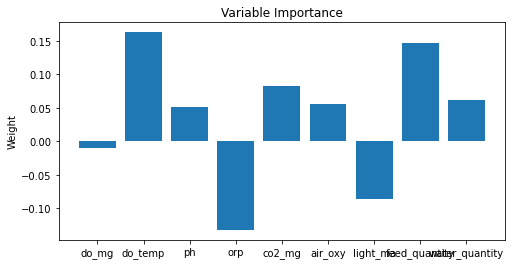

In [18]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [19]:
japonica_validation_features_X

,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,
2021-07-21 00:00:00,7.91,30.2,5.563,196.44,13.68,0.00,3.95,0.0,0.0
2021-07-21 00:10:00,7.85,30.2,5.539,198.21,13.52,0.00,3.97,0.0,0.0
2021-07-21 00:20:00,8.00,30.2,5.518,199.79,13.45,0.00,3.96,0.0,0.0
2021-07-21 00:30:00,8.10,30.2,5.497,201.34,13.28,0.00,3.95,0.0,0.0
2021-07-21 00:40:00,8.03,30.2,5.479,202.41,13.17,0.00,3.96,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-09-10 23:10:00,9.19,28.8,4.985,263.09,17.60,7.90,3.97,0.0,0.0
2021-09-10 23:20:00,9.23,28.8,4.978,263.00,17.60,7.87,3.94,0.0,0.0
2021-09-10 23:30:00,9.16,28.8,4.967,263.31,17.64,7.83,3.97,0.0,0.0


In [20]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6894 nVar: 9


In [21]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 6894 nVar: 1
nCar: 6894 nVar: 1


6894


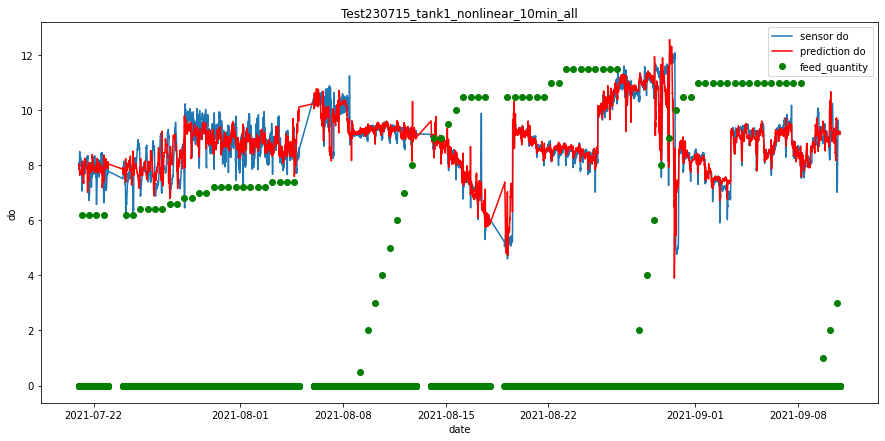

216/216 [==============================] - 1s 3ms/step - loss: 0.3278
MSE // MAE // R-squared  0.32776448130607605


In [22]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [23]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1422 nVar: 9


In [24]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1422 nVar: 1
nCar: 1422 nVar: 1


1422


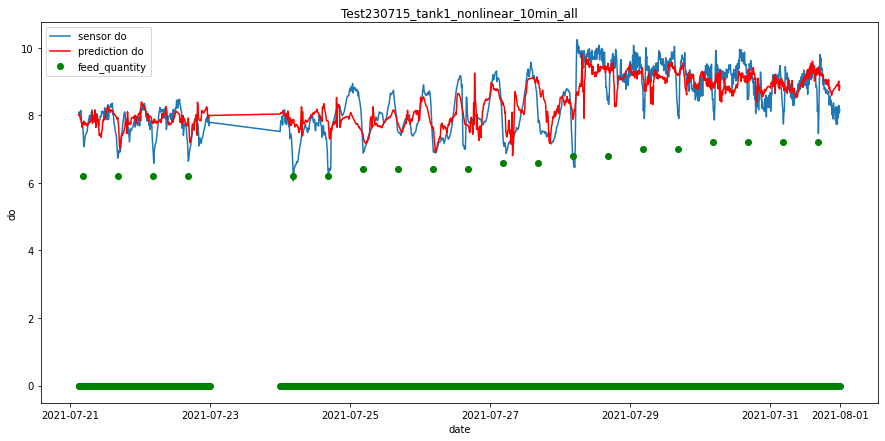

45/45 [==============================] - 0s 3ms/step - loss: 0.2523
MSE // MAE // R-squared  0.25230708718299866


In [25]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [26]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 126 nVar: 9


In [27]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 126 nVar: 1
nCar: 126 nVar: 1


126


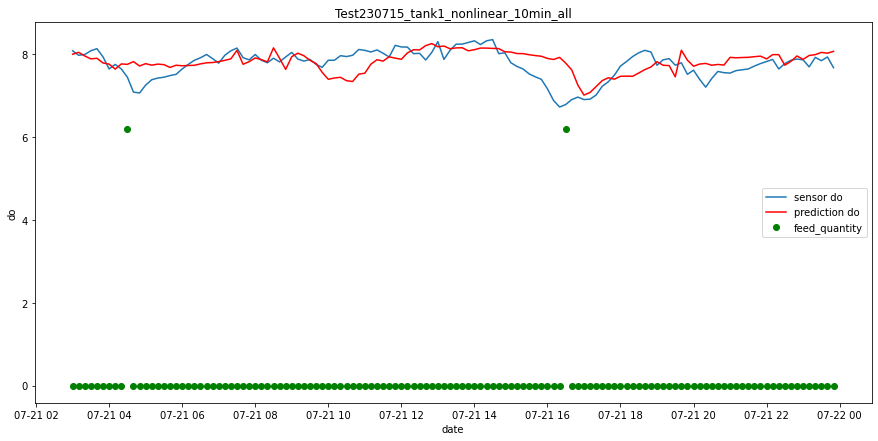

4/4 [==============================] - 0s 4ms/step - loss: 0.1107
MSE // MAE // R-squared  0.11071053892374039


In [28]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [29]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 9


In [30]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 1
nCar: 72 nVar: 1


72


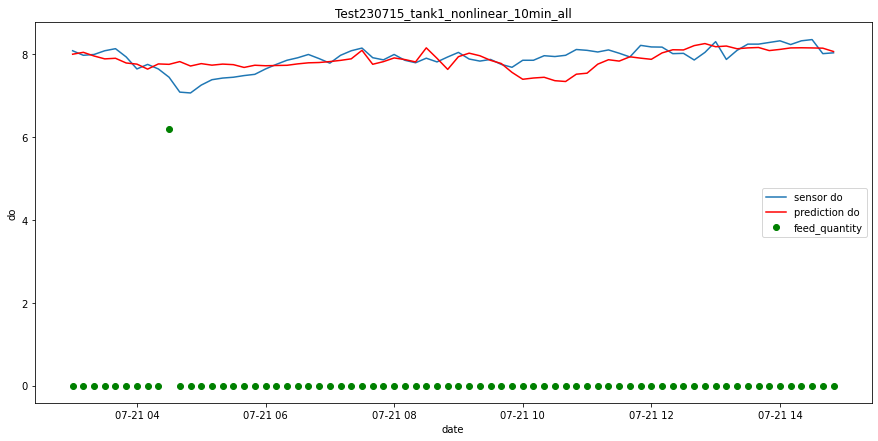

3/3 [==============================] - 0s 4ms/step - loss: 0.0733
MSE // MAE // R-squared  0.07327304780483246


In [31]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [32]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 9


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [33]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 72 nVar: 1
nCar: 72 nVar: 1


72


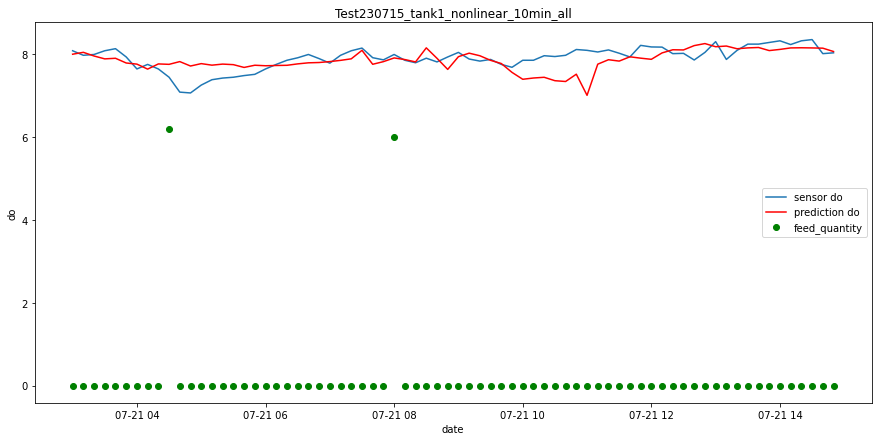

3/3 [==============================] - 0s 3ms/step - loss: 0.0855
MSE // MAE // R-squared  0.08545457571744919


In [34]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)